In [1]:
%matplotlib inline
from solveFull import linearSolve_krylov as linearSolve
import numpy as np, matplotlib.pyplot as plt
import pystokes

In [2]:
def rotation(vector,alpha, beta, gamma):
    rotmat = np.array([[np.cos(beta)*np.cos(gamma), np.sin(alpha)*np.sin(beta)*np.cos(gamma) 
                        - np.cos(alpha)*np.sin(gamma), np.cos(alpha)*np.sin(beta)*np.cos(gamma)
                        + np.sin(alpha)*np.sin(gamma)],
                       [np.cos(beta)*np.sin(gamma),
                        np.sin(alpha)*np.sin(beta)*np.sin(gamma) + np.cos(alpha)*np.cos(gamma),
                        np.cos(alpha)*np.sin(beta)*np.sin(gamma) - np.sin(alpha)*np.cos(gamma)],
                       [-np.sin(beta),
                        np.sin(alpha)*np.cos(beta),
                        np.cos(alpha)*np.cos(beta)]])
    return np.dot(rotmat, vector)

In [3]:
# particle radius, self-propulsion speed, number and fluid viscosity
b, Np, eta = 1.0, 2, 0.1

## squirmer
D0  = 1.0      
S0  = 3/50*D0    # beta = 1 (positive beta is a puller (negative V2s)) - not sure which sign!

In [4]:
## initialise 
#initial position
r = np.array([-1.5,1.5, 0.,0. , 0., 0.])

#initial orientation
p = np.array([0., 0., 0.,0., 1.,1.])

##rotate particles 50deg towards each other
p[::Np] = rotation(p[::Np], 0., 25*2*np.pi/360, 0.)
p[1::Np] = rotation(p[1::Np], 0., -25*2*np.pi/360, 0.)


# initial slip modes
S = np.zeros(9*Np)
D = np.zeros(3*Np)
for i in range(Np):
    ## S in order: xx, xy, xz, yx, yy, yz, zx, zy, zz
    S[i]       = S0*(3*p[i]*p[i] -1.)
    S[i + Np]  = S0*(3*p[i]*p[i+Np])
    S[i + 2*Np]= S0*(3*p[i]*p[i+2*Np])
    S[i + 3*Np]= S0*(3*p[i+Np]*p[i])
    S[i + 4*Np]= S0*(3*p[i+Np]*p[i+Np]-1.)
    S[i + 5*Np]= S0*(3*p[i+Np]*p[i+2*Np]) 
    S[i + 6*Np]= S0*(3*p[i+2*Np]*p[i+Np])
    S[i + 7*Np]= S0*(3*p[i+2*Np]*p[i+Np])
    S[i + 8*Np]= S0*(3*p[i+2*Np]*p[i+2*Np] - 1.)
    
    D[i]       = D0*p[i]
    D[i+Np]    = D0*p[i+Np]
    D[i+2*Np]  = D0*p[i+2*Np]

In [5]:
def rhs(rp): ##change this to give polarisation directly
    """
    Function that gives rhs for equations dr/dt=v and dp/dt= o x p
    """
    
    #position and angle theta (relative to initial angle)
    r = rp[0:3*Np]; p = rp[3*Np:6*Np]
    
    ## make sure orientations remain unit length
    norm_p1 = np.dot(p[::Np],p[::Np])
    norm_p2 = np.dot(p[1::Np],p[1::Np])
    
    p[::Np] = p[::Np]/np.sqrt(norm_p1)
    p[1::Np] = p[1::Np]/np.sqrt(norm_p2)
    
    
    F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)
    
    for i in range(Np):          
        F[i]      = 0.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 0.0 
        
        T[i]      = 0.0
        T[i+Np]   = 0.0
        T[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
        
        S[i]       = S0*(3*p[i]*p[i] -1.)
        S[i + Np]  = S0*(3*p[i]*p[i+Np])
        S[i + 2*Np]= S0*(3*p[i]*p[i+2*Np])
        S[i + 3*Np]= S0*(3*p[i+Np]*p[i])
        S[i + 4*Np]= S0*(3*p[i+Np]*p[i+Np]-1.)
        S[i + 5*Np]= S0*(3*p[i+Np]*p[i+2*Np]) 
        S[i + 6*Np]= S0*(3*p[i+2*Np]*p[i+Np])
        S[i + 7*Np]= S0*(3*p[i+2*Np]*p[i+Np])
        S[i + 8*Np]= S0*(3*p[i+2*Np]*p[i+2*Np] - 1.)
        
        D[i]       = D0*p[i]
        D[i+Np]    = D0*p[i+Np]
        D[i+2*Np]  = D0*p[i+2*Np]

    
    #update repulsive force at position r
    forces.lennardJones(F, r, lje=5.0, ljr=2.1*b)
    
    #update velocity and angular velocity at r, acted on by F and T, and with slip modes S an D
    ls.RBM(v, o, r, F, T, S, D)
    
    dpdt = np.zeros(3*Np)
    
    for i in range(Np):
        dpdt[i]      = o[i+Np]*p[i+2*Np] - o[i+2*Np]*p[i+Np]    
        dpdt[i+Np]   = o[i+2*Np]*p[i   ] - o[i     ]*p[i+2*Np]  
        dpdt[i+2*Np] = o[i     ]*p[i+Np] - o[i+Np  ]*p[i]
        

    
    #return velocity and angular velocity cross orientation as right-hand side
    return np.concatenate( (v,dpdt) )

In [6]:
def simulate(rth0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=100000, **kwargs):
    
    def dxdtEval(rth,t):
        return rhs(rth)
    
    if integrator=='BDF': ## weird handling for this method
        from scipy.integrate import BDF
        X = BDF(lambda t, xt: dxdtEval(xt,t), Ti, rth0, Tf)
        
    if integrator=='odeint':
        from scipy.integrate import odeint
        time_points=np.linspace(Ti, Tf, Npts+1);
        X = odeint(dxdtEval, rth0, time_points, mxstep=maxNumSteps, **kwargs)
        
    if integrator=='solve_ivp':
        from scipy.integrate import solve_ivp
        time_points=np.linspace(Ti, Tf, Npts+1)                                                          
        X = solve_ivp(lambda t, xt: dxdtEval(xt,t), [0,Tf], rth0, 
                         t_eval=None, **kwargs)
        
    return X

In [7]:
%%time
#initiallize system and forces
ls = linearSolve(b, Np, eta)
forces  = pystokes.forceFields.Forces(particles=Np)

#simulate the resulting system
rp0 = np.concatenate((r,p))
Tf = 500.
Npts = 10

X = simulate(rp0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=1000,
             method='BDF')
X.message

CPU times: user 5min 21s, sys: 253 ms, total: 5min 21s
Wall time: 4min 56s


'The solver successfully reached the end of the integration interval.'

In [8]:
pos = X.y.T[:,0:3*Np]
times = X.t

In [9]:
pos1 = pos[:,::Np]
pos2 = pos[:,1::Np]

In [10]:
plt.rcParams.update({'font.size': 17})

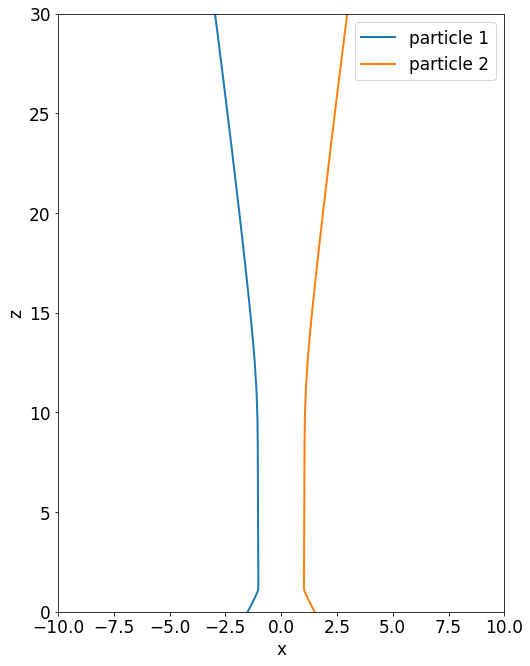

In [11]:
##x-y plot like in Ishikawa
plt.figure(figsize=(8,11))
plt.plot(pos1[:,0], pos1[:,2], label='particle 1', lw=2)
plt.plot(pos2[:,0], pos2[:,2], label='particle 2', lw=2)
plt.xlabel('x')
plt.ylabel('z')
plt.ylim(0,30)
plt.xlim(-10,10)
plt.legend()
plt.show()

In [12]:
## minimum distance between the two particles
rmin = np.amin(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2))
rmax = np.amax(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2))
rmin, rmax

(2.0427883166107863, 22.457021962647495)

In [13]:
minIndex = np.where(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2)==rmin)
#minIndex[0][0] -= 18
xik,yik,zik = (pos1[minIndex,:]-pos2[minIndex,:])[0][0]
minIndex

(array([17]),)

In [14]:
xik,yik,zik ##they go out of plane? not anymore! 

(-2.0427883166107863, 0.0, 1.4765966227514582e-13)

In [15]:
##why does Krylov solver go so wrong? seems to introduce numerical error. 

## Try symmetry factor corrected matrix elements with a direct solver? 

In [16]:
print(pos1[:,0] + pos2[:,0])

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.77635684e-15  4.21884749e-15  5.77315973e-15  4.44089210e-15
  7.57172103e-14  1.87183602e-13  2.77777801e-13  2.33146835e-13
  2.12274642e-13  2.12274642e-13  2.70006240e-13  2.97095681e-13
 -9.98756633e-13 -4.99378316e-13  2.17315055e-12  6.98818781e-12
  1.42217349e-11  4.43425296e-11  8.29469826e-11  1.35253586e-10
  1.99073202e-10  2.92735391e-10  4.39777992e-10  6.24299057e-10
  8.60812976e-10  1.06417986e-09  1.23573152e-09  1.38606171e-09
  1.70851777e-09  1.99539540e-09  2.25928121e-09  2.65828293e-09
  3.08281178e-09  3.55848417e-09  4.08345180e-09  4.94744956e-09
  5.74365178e-09  6.44340581e-09  7.59096075e-09  8.48941362e-09]


In [17]:
orientations = X.y.T[:,3*Np:6*Np]
or1 = orientations[:,::Np]
or2 = orientations[:,1::Np]

In [18]:
or1[:,0] + or2[:,0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -5.55111512e-16, -2.77555756e-16, -3.33066907e-16, -2.22044605e-16,
        7.54951657e-15, -1.14352972e-14, -3.06421555e-14, -8.79851747e-14,
       -8.48210391e-14, -2.04558592e-14, -4.26325641e-14, -1.24900090e-13,
       -5.49671419e-13,  5.16281462e-13,  2.89659095e-12,  6.18496573e-12,
        1.00702086e-11,  2.14685908e-11,  3.16953963e-11,  4.19452806e-11,
        4.78584117e-11,  7.08607062e-11,  1.08592690e-10,  1.48702051e-10,
        1.69722320e-10,  1.59514624e-10,  1.38527523e-10,  1.21590099e-10,
        1.02277048e-10,  9.29754884e-11,  8.61777594e-11,  8.73223993e-11,
        9.70941105e-11,  1.08805714e-10,  1.17070825e-10,  1.11057497e-10,
        9.65956481e-11,  8.36928998e-11,  6.88868546e-11,  6.81072004e-11])

In [19]:
or1[:,2] - or2[:,2]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.44328993e-15,  1.11022302e-16,  0.00000000e+00, -1.11022302e-16,
        4.68514116e-14,  4.15223411e-14,  3.21964677e-14, -1.16573418e-13,
       -9.33697564e-14,  1.57984736e-13,  1.27231559e-13,  1.65867320e-13,
       -1.51545443e-12, -9.83990667e-13, -7.16426918e-13,  1.88737914e-15,
        6.67910172e-13,  4.20441459e-12,  4.89741581e-12,  6.47459864e-12,
        8.28825897e-12,  1.24753541e-11,  1.92317273e-11,  2.58100208e-11,
        2.71092038e-11,  2.41376918e-11,  2.03405071e-11,  1.76443304e-11,
        1.44715351e-11,  1.26887389e-11,  1.14857013e-11,  1.15228938e-11,
        1.25799371e-11,  1.39549483e-11,  1.49157353e-11,  1.38746792e-11,
        1.22039046e-11,  1.05380149e-11,  8.61044569e-12,  8.49831316e-12])

In [20]:
X.nfev

134